# Monthly Missing Data Aggregation and Analysis Across Multiple Data Sources


Missing Values Report Generator
---
This script loops over a root folder containing multiple data source directories.
Each data source contains monthly subfolders with CSV files.
It aggregates missing value counts for a specified set of variables across all files
and calculates the percentage of missing data for each variable.

Output:
An Excel file "aggregated_missing_values_with_percentages.xlsx" is created containing
the aggregated missing values report.

Usage:
Ensure the root_folder path is updated as needed and that all CSV files use semicolon (;) delimiters.

In [1]:
# ------------------------------
# Import libraries
# ------------------------------
import os
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pandas as pd


# ------------------------------
# Configuration
# ------------------------------

# Define the root folder where all data sources are located
root_folder = "/Users/alfonso/Desktop/JOCAS"  # Update this path if needed

# Define the variables (columns) to check for missing values
variables = [
    "job_title", "job_ROME_code", "job_qualification", "contractType", 
    "contractDuration_min", "contractDuration_max", "contractDuration_period", 
    "contractDuration_value", "workTime_hours", "workTime_category", 
    "workTime_value", "description_job", "description_profil", 
    "description_entreprise", "description_full", "location_label", 
    "location_zipcode", "location_departement", "location_country", 
    "salary_min", "salary_max", "salary_period", "salary_value", 
    "salary_hourly_mean", "salary_hourly_min", "salary_hourly_max", 
    "entreprise_nom", "entreprise_siren", "entrepriseSecteur_NAF88", 
    "entrepriseSecteur_NAF21", "partner_name", "partner_status", 
    "teleworking_accepted", "teleworking_type", "teleworking_mentioned", 
    "experience_min", "experience_max", "education_level", "education_field"
]

# List to store aggregated missing values report for each monthly folder
missing_values_report = []


# ------------------------------
# Main Processing Loop
# ------------------------------

# Iterate through each data source folder
for source_folder in os.listdir(root_folder):
    source_path = os.path.join(root_folder, source_folder)
    if os.path.isdir(source_path):
        # Iterate through each monthly subfolder within the data source folder
        for month_folder in os.listdir(source_path):
            month_path = os.path.join(source_path, month_folder)
            if os.path.isdir(month_path):
                # Initialize dictionary for aggregating counts for this month
                monthly_report = {"Month": month_folder, "Source": source_folder}
                # Initialize missing and total counts for each variable
                for var in variables:
                    monthly_report[f"{var}_missing"] = 0
                    monthly_report[f"{var}_total"] = 0

                # Process each CSV file in the monthly folder
                for file_name in os.listdir(month_path):
                    if file_name.lower().endswith('.csv'):
                        file_path = os.path.join(month_path, file_name)
                        try:
                            # Read CSV file while loading only the required columns
                            df = pd.read_csv(
                                file_path,
                                header=0,
                                sep=';',
                                on_bad_lines='skip',
                                low_memory=False,
                                quoting=csv.QUOTE_MINIMAL,
                                escapechar='\\',
                                usecols=variables
                            )
                            # Compute missing values (vectorized)
                            missing_counts = df.isna().sum()
                            total_rows = len(df)
                            
                            # Update counts for each variable
                            for var in variables:
                                monthly_report[f"{var}_missing"] += missing_counts[var]
                                monthly_report[f"{var}_total"] += total_rows
                        except Exception as e:
                            # Log errors and continue processing other files
                            with open("error_log.txt", "a") as log_file:
                                log_file.write(f"{file_path}: {e}\n")
                # Append the monthly aggregated data to the report list
                missing_values_report.append(monthly_report)

# Convert monthly reports into a DataFrame
df_monthly = pd.DataFrame(missing_values_report)


# ------------------------------
# Aggregation at Source Level
# ------------------------------

# Group by Source and aggregate across months
aggregated = df_monthly.groupby("Source").agg(
    nb_month_covered=("Month", "nunique"),
    **{f"{var}_missing": (f"{var}_missing", "sum") for var in variables},
    **{f"{var}_total": (f"{var}_total", "sum") for var in variables}
).reset_index()

# Calculate share of observations for each source.
# Using 'job_title_total' as a proxy for total observations per source.
global_total_obs = aggregated["job_title_total"].sum()
aggregated["share_observations"] = (aggregated["job_title_total"] / global_total_obs * 100).round(2)

# Calculate share of missing values (in percentages) for each variable at the source level
for var in variables:
    aggregated[f"{var}_share_missings"] = (aggregated[f"{var}_missing"] / aggregated[f"{var}_total"] * 100).round(2)

# Prepare the final dataset with selected columns and rename for clarity
final_columns = ["Source", "nb_month_covered", "share_observations"] + [f"{var}_share_missings" for var in variables]
final_report = aggregated[final_columns].rename(columns={"Source": "source"})

# ------------------------------
# Append Final Total Row
# ------------------------------

# Compute overall totals and percentages across all sources
final_row = {}
final_row["source"] = "Total"
final_row["nb_month_covered"] = aggregated["nb_month_covered"].sum()
final_row["share_observations"] = 100.00  # overall share is 100%

for var in variables:
    total_missing = aggregated[f"{var}_missing"].sum()
    total_count = aggregated[f"{var}_total"].sum()
    share_missing = round((total_missing / total_count * 100), 2) if total_count > 0 else 0.00
    final_row[f"{var}_share_missings"] = share_missing

# Append the final row to the final_report DataFrame
final_report = final_report.append(final_row, ignore_index=True)

# ------------------------------
# Output Final Report
# ------------------------------

output_file = "aggregated_source_level_missing_values.xlsx"
final_report.to_excel(output_file, index=False)
print(f"Aggregated source-level missing values report has been saved as '{output_file}'")

# Print the table
final_report.head(5)


Aggregated missing values report has been saved as 'aggregated_missing_values_with_percentages.xlsx'


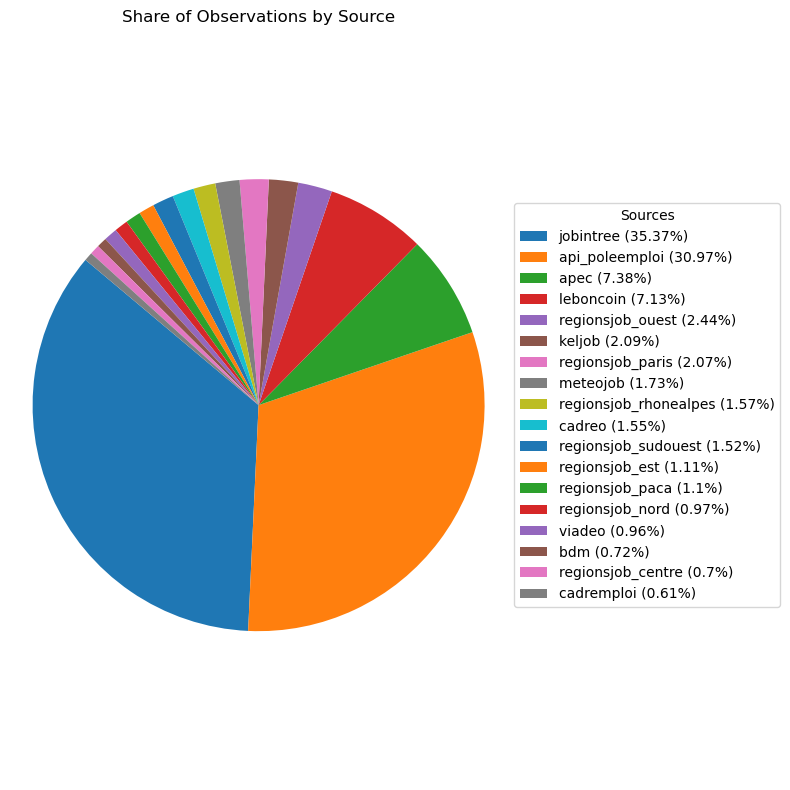

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


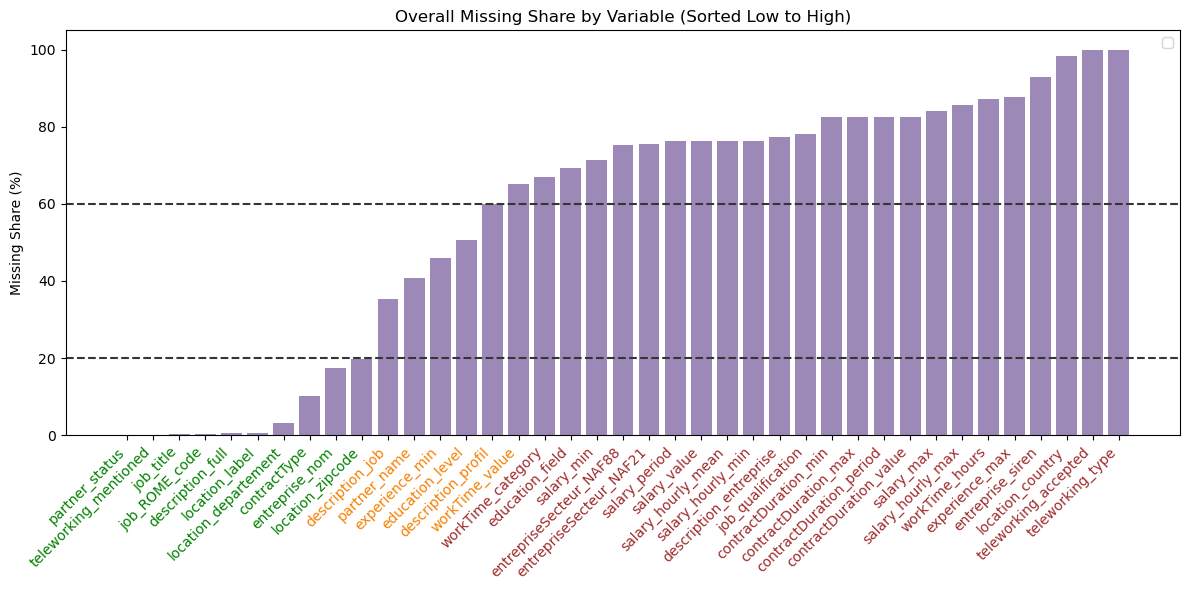

In [41]:
# ---------------------------
# Pie Chart with Separate Legend
# ---------------------------

# Sort sources by share_observations (descending) so the legend is ordered
source_report_sorted = source_report.sort_values('share_observations', ascending=False)

fig, ax = plt.subplots(figsize=(8, 8))

# Create the pie chart, capturing only wedges (patches) and texts
wedges, _ = ax.pie(
    source_report_sorted['share_observations'],
    startangle=140
)

# Build the legend, combining source name and share in the label
legend_labels = [
    f"{row['source']} ({row['share_observations']}%)"
    for _, row in source_report_sorted.iterrows()
]

# Place the legend on the right
ax.legend(
    wedges,
    legend_labels,
    title="Sources",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

ax.set_title("Share of Observations by Source")
ax.axis('equal')  # Ensures the pie is a circle
plt.tight_layout()
plt.show()

# ---------------------------
# Bar Chart of Overall Missing Share by Variable (Sorted)
# ---------------------------
# Extract variable names and their overall missing share percentages
var_missing_pairs = [
    (var, total_row[f"{var}_share_missings"]) for var in variables
]

# Sort by missing share from low to high
var_missing_pairs_sorted = sorted(var_missing_pairs, key=lambda x: x[1])
vars_sorted, shares_sorted = zip(*var_missing_pairs_sorted)

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(vars_sorted, shares_sorted, color='#9c89b8')
plt.ylabel("Missing Share (%)")
plt.title("Overall Missing Share by Variable (Sorted Low to High)")

# Rotate x labels diagonally (45°) for better readability
plt.xticks(rotation=45, ha='right')

# Add dashed horizontal lines at 20% (orange) and 60% (red)
plt.axhline(y=20, color='#353535', linestyle='--', linewidth=1.5)
plt.axhline(y=60, color='#353535', linestyle='--', linewidth=1.5)

# Optionally add a legend for the thresholds
plt.legend()

# Color the x-axis tick labels based on missing share thresholds
ax = plt.gca()
for tick, share in zip(ax.get_xticklabels(), shares_sorted):
    if share < 20:
        tick.set_color('green')
    elif share < 66:
        tick.set_color('#f77f00')
    else:
        tick.set_color('#9e2a2b')

plt.tight_layout()
plt.show()

In [43]:
import os
import pandas as pd
import csv
from collections import Counter

# ------------------------------
# Configuration
# ------------------------------

# Define the root folder where all data sources are located
root_folder = "/Users/alfonso/Desktop/JOCAS"  # Update this path as needed

# Define the variables for which to extract category proportions
vars_interest = ["contractType", "workTime_category"]

# ------------------------------
# Data Aggregation
# ------------------------------

# Initialize counters for each variable
category_counts = {var: Counter() for var in vars_interest}
total_counts = {var: 0 for var in vars_interest}

# Traverse through the folder structure
for source_folder in os.listdir(root_folder):
    source_path = os.path.join(root_folder, source_folder)
    if os.path.isdir(source_path):
        for month_folder in os.listdir(source_path):
            month_path = os.path.join(source_path, month_folder)
            if os.path.isdir(month_path):
                for file_name in os.listdir(month_path):
                    if file_name.lower().endswith('.csv'):
                        file_path = os.path.join(month_path, file_name)
                        try:
                            # Read only the columns we need
                            df = pd.read_csv(
                                file_path,
                                header=0,
                                sep=';',
                                on_bad_lines='skip',
                                low_memory=False,
                                quoting=csv.QUOTE_MINIMAL,
                                escapechar='\\',
                                usecols=vars_interest
                            )
                            # Update counts for each variable
                            for var in vars_interest:
                                # Drop missing values for this variable
                                series = df[var].dropna()
                                total_counts[var] += len(series)
                                category_counts[var].update(series.tolist())
                        except Exception as e:
                            with open("error_log.txt", "a") as log_file:
                                log_file.write(f"{file_path}: {e}\n")

# ------------------------------
# Compute Proportions
# ------------------------------

# Convert counts to proportions (percentage)
proportions = {}
for var in vars_interest:
    proportions[var] = {
        cat: (count / total_counts[var] * 100) 
        for cat, count in category_counts[var].items()
    }

# ------------------------------
# Display the Results
# ------------------------------

for var in vars_interest:
    print(f"Proportions for '{var}':")
    for category, prop in proportions[var].items():
        print(f"  {category}: {prop:.2f}%")
    print()

Proportions for 'contractType':
  CDI: 60.38%
  Independant: 1.10%
  MIS: 16.31%
  CDD: 18.38%
  Stage: 1.00%
  Alternance: 0.92%
  Franchise: 0.33%
  Apprentissage: 0.15%
  Apprentissage/Alternance: 0.08%
  Contractuel de la fonction publique: 0.01%
  SAI: 0.40%
  Avis de concours: 0.00%
  VIE: 0.00%
  Titulaire de la fonction publique: 0.00%
  CDD/MIS: 0.34%
  Contrat étranger: 0.01%
  CDI/MIS: 0.05%
  Independant/Franchise: 0.26%
  Stage/Alternance: 0.01%
  Bénévolat: 0.00%
  CCE: 0.14%
  TTI: 0.01%
  DDI: 0.03%
  DIN: 0.01%
  REP: 0.05%
  CDS: 0.00%
  TOUSSAINT SARL: 0.00%

Proportions for 'workTime_category':
  FULL_TIME: 44.01%
  PART_TIME: 1.48%
  Temps plein: 18.80%
  Temps partiel: 2.43%
  FULL_TIME_INFER: 30.65%
  PART_TIME_INFER: 2.62%

